# Abstract

Data can be found <a href="https://www.kaggle.com/datasets/jocelyndumlao/cardiovascular-disease-dataset">here</a>

In [70]:
#| echo: false

#Import libraries
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
#| echo: false
### ONLY RUN ONCE ###
#Download dataset
#od.download("https://www.kaggle.com/datasets/jocelyndumlao/cardiovascular-disease-dataset")

In [3]:
#| echo: false

#Read in data
df = pd.read_csv("kaggle_datasets/Cardiovascular_Disease_Dataset/Cardiovascular_Disease_Dataset.csv")

In [4]:
#| echo: false

#Check data read in correctly
df.head()

,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
0,103368,53,1,2,171,0,0,1,147,0,5.3,3,3,1
1,119250,40,1,0,94,229,0,1,115,0,3.7,1,1,0
2,119372,49,1,2,133,142,0,0,202,1,5.0,1,0,0
3,132514,43,1,0,138,295,1,1,153,0,3.2,2,2,1
4,146211,31,1,1,199,0,0,2,136,0,5.3,3,2,1


In [5]:
#| echo: false

#Check for nulls
df.isna().sum()

patientid            0
age                  0
gender               0
chestpain            0
restingBP            0
serumcholestrol      0
fastingbloodsugar    0
restingrelectro      0
maxheartrate         0
exerciseangia        0
oldpeak              0
slope                0
noofmajorvessels     0
target               0
dtype: int64

In [6]:
#| echo: false

#Check datatypes
df.dtypes

patientid              int64
age                    int64
gender                 int64
chestpain              int64
restingBP              int64
serumcholestrol        int64
fastingbloodsugar      int64
restingrelectro        int64
maxheartrate           int64
exerciseangia          int64
oldpeak              float64
slope                  int64
noofmajorvessels       int64
target                 int64
dtype: object

In [19]:
#| echo: false

#Add gender label column for plotting purposes
df = df.assign(gender_label = lambda x: np.where(x.gender == 1, "Male", "Female"))

# Exploratory Data Analysis

In [7]:
#| echo: false

#Get descriptive stats
df.describe()

,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
count,1.000000e+03,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,5.048704e+06,49.24200,0.765000,0.980000,151.747000,311.447000,0.296000,0.748000,145.477000,0.498000,2.707700,1.540000,1.222000,0.580000
std,2.895905e+06,17.86473,0.424211,0.953157,29.965228,132.443801,0.456719,0.770123,34.190268,0.500246,1.720753,1.003697,0.977585,0.493805
min,1.033680e+05,20.00000,0.000000,0.000000,94.000000,0.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.536440e+06,34.00000,1.000000,0.000000,129.000000,235.750000,0.000000,0.000000,119.750000,0.000000,1.300000,1.000000,0.000000,0.000000
50%,4.952508e+06,49.00000,1.000000,1.000000,147.000000,318.000000,0.000000,1.000000,146.000000,0.000000,2.400000,2.000000,1.000000,1.000000
75%,7.681877e+06,64.25000,1.000000,2.000000,181.000000,404.250000,1.000000,1.000000,175.000000,1.000000,4.100000,2.000000,2.000000,1.000000
max,9.990855e+06,80.00000,1.000000,3.000000,200.000000,602.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,1.000000


In [8]:
#| echo: false

#Get dimensions
df.shape

(1000, 14)

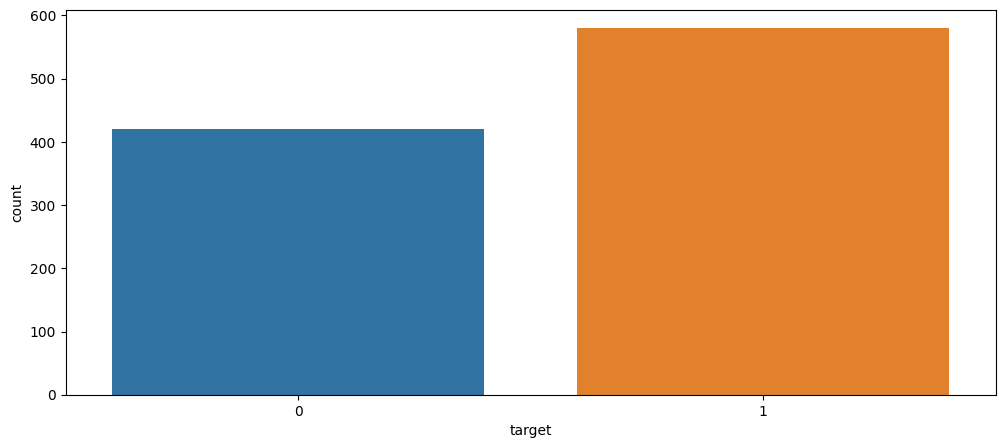

In [9]:
#| echo: false

#Plot bar plot of split between 0s and 1s
plt.figure(figsize=(12,5))
sns.countplot(x='target', data=df);

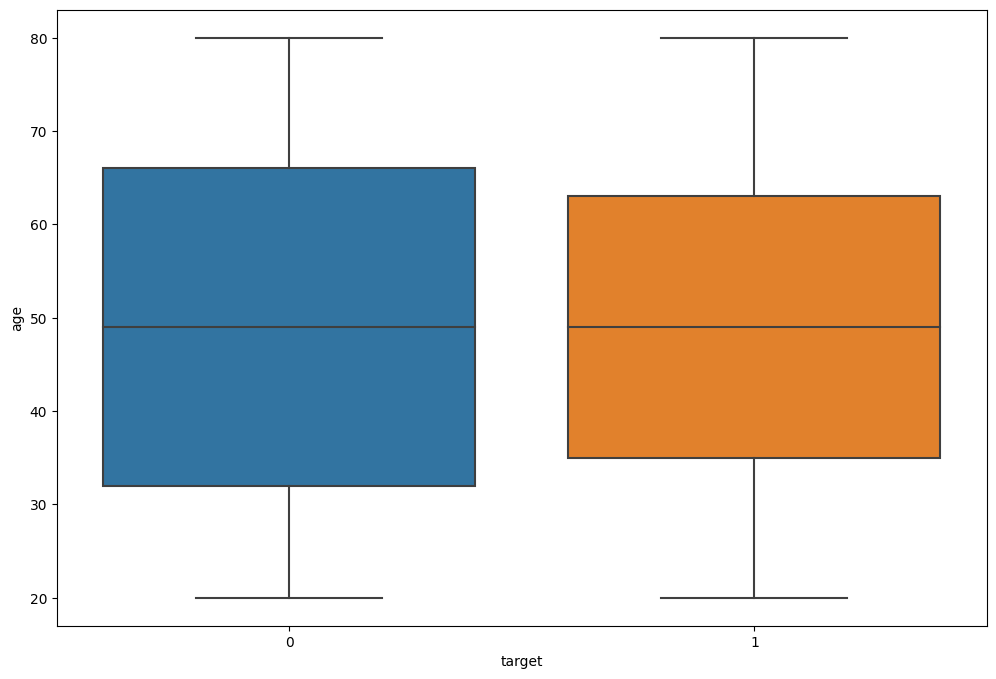

In [10]:
#| echo: false

#Check box plot of distribution between 0s and 1s and age
plt.figure(figsize=(12,8))
sns.boxplot(x='target', y='age', data=df);

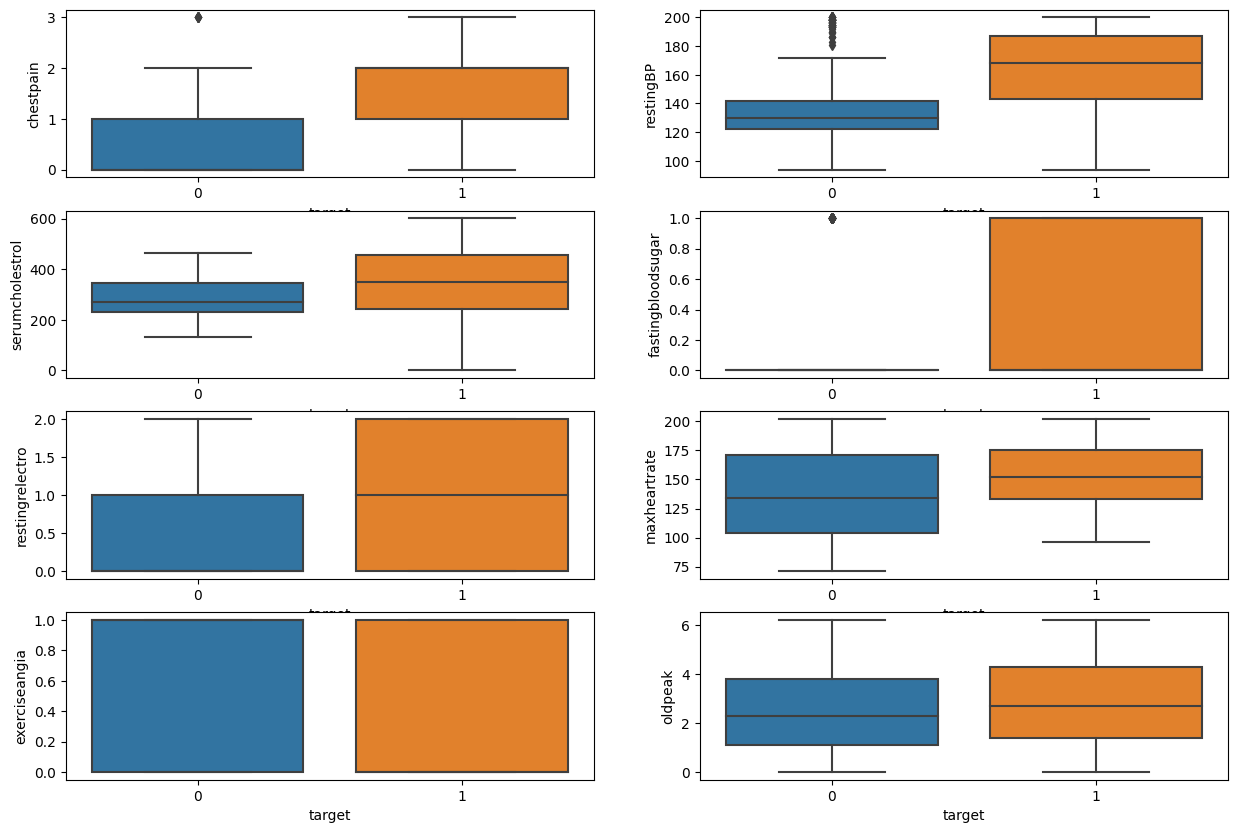

In [11]:
#| echo: false

#Check out box plots for more features between 0s and 1s
feat_list = df.columns[3:11].to_list()

#Instantiate subplots fig and axes
fig, axes = plt.subplots(4,2, figsize=(15,10))

for i, ax in enumerate(axes.flatten()):
    sns.boxplot(x='target', y=feat_list[i], data=df, ax=ax)

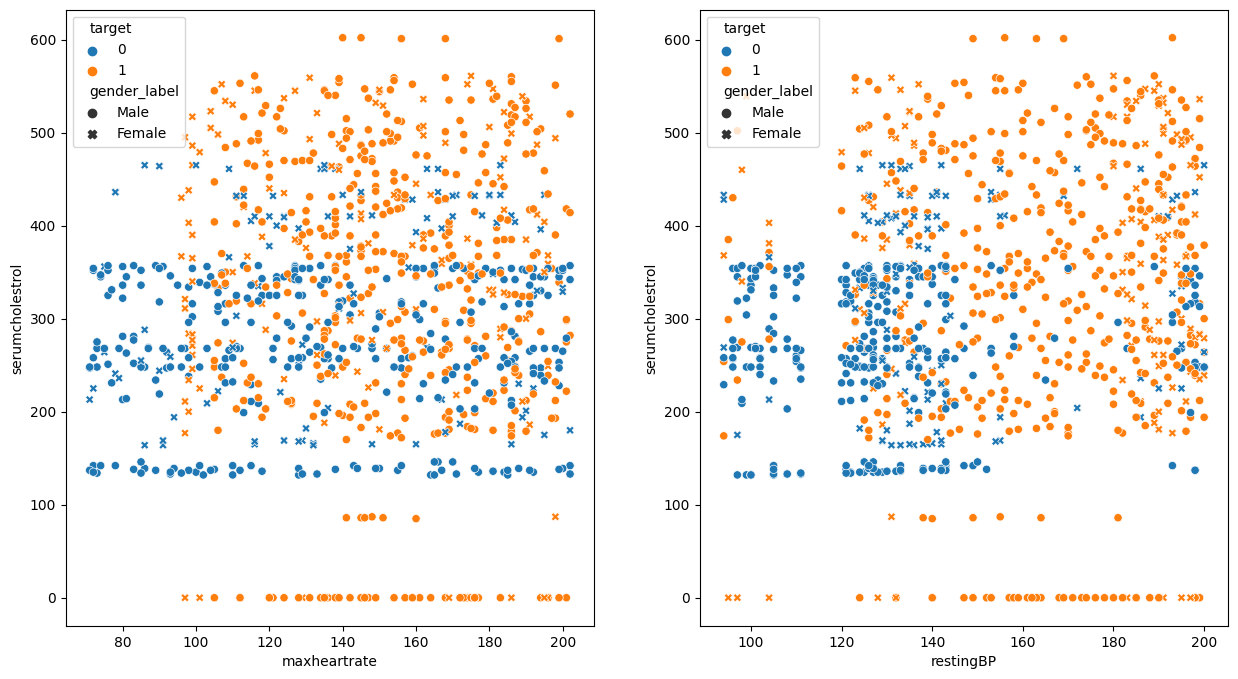

In [20]:
#| echo: false

#Check out scatterplot between maxheartrate and cholestrol and scatterplot between restingBP and cholestrol with hue target and style gender
fig, axes = plt.subplots(1,2, figsize=(15,8))

sns.scatterplot(x='maxheartrate', y='serumcholestrol', hue='target', style='gender_label', data=df, ax=axes[0])
sns.scatterplot(x='restingBP', y='serumcholestrol', hue='target', style='gender_label', data=df, ax=axes[1]);

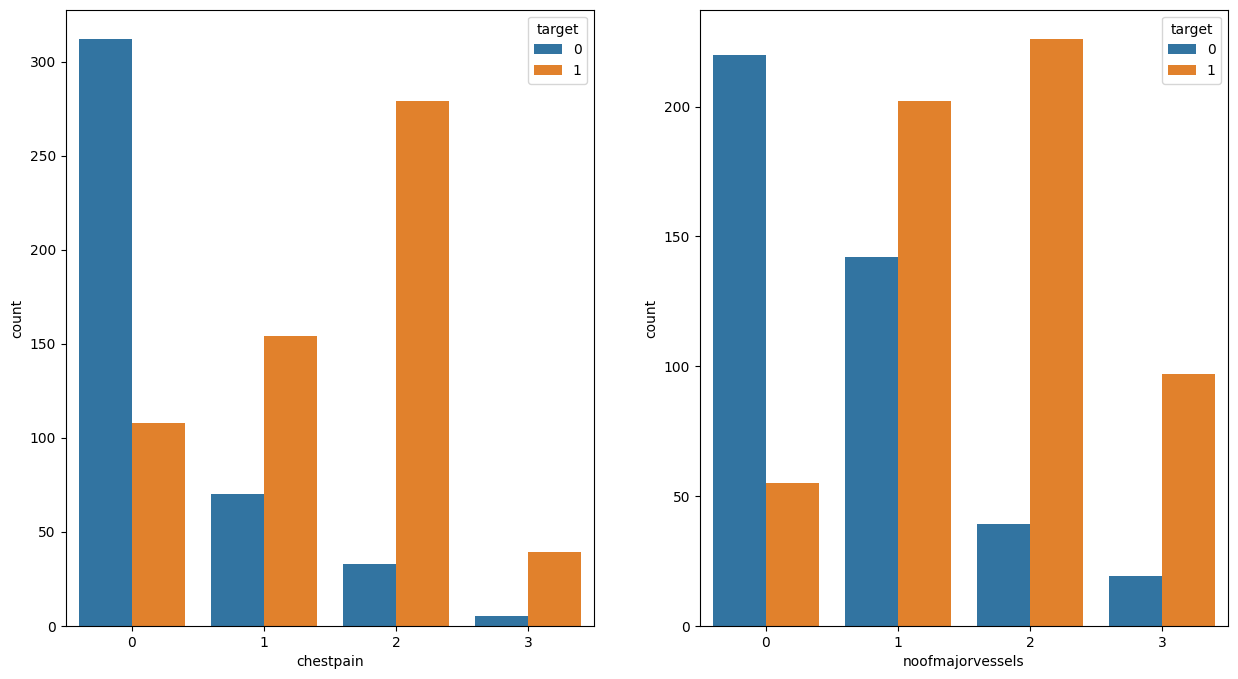

In [34]:
#| echo: false

#Plot count plots of those with chestpain, noofmajorvessels by target and then gender
fig, axes = plt.subplots(1,2, figsize=(15,8))

sns.countplot(x='chestpain', hue='target', data=df, ax=axes[0])
sns.countplot(x='noofmajorvessels', hue='target', data=df, ax=axes[1]);

In [49]:
#| echo: false

#Correlation matrix
df.iloc[:, 1:13].corr()

,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels
age,1.000000,-0.024717,0.037731,-0.016126,0.035439,0.049732,0.067736,-0.040092,-0.037581,-0.026020,-0.015334,0.025407
gender,-0.024717,1.000000,0.035402,-0.069727,-0.120759,0.023560,-0.046634,0.064606,-0.051746,0.331457,-0.051957,0.029376
chestpain,0.037731,0.035402,1.000000,0.222267,0.174731,0.232059,0.256316,0.114496,-0.027376,0.101345,0.472731,0.285156
restingBP,-0.016126,-0.069727,0.222267,1.000000,0.126523,0.192063,0.219887,0.095569,-0.046545,-0.004225,0.376711,0.263194
serumcholestrol,0.035439,-0.120759,0.174731,0.126523,1.000000,0.278337,0.101767,0.038967,0.029422,-0.025910,0.165569,0.132419
fastingbloodsugar,0.049732,0.023560,0.232059,0.192063,0.278337,1.000000,0.143982,0.096528,0.011356,0.015311,0.242734,0.182246
restingrelectro,0.067736,-0.046634,0.256316,0.219887,0.101767,0.143982,1.000000,0.099991,-0.032489,0.040291,0.343280,0.204684
maxheartrate,-0.040092,0.064606,0.114496,0.095569,0.038967,0.096528,0.099991,1.000000,0.015536,0.044614,0.201515,0.122763
exerciseangia,-0.037581,-0.051746,-0.027376,-0.046545,0.029422,0.011356,-0.032489,0.015536,1.000000,-0.003296,-0.017783,-0.017513
oldpeak,-0.026020,0.331457,0.101345,-0.004225,-0.025910,0.015311,0.040291,0.044614,-0.003296,1.000000,0.208789,0.086992


# Model Creation

In [96]:
#| echo: false

#Split features and target
X = df.drop(['patientid', 'target', 'gender_label'], axis=1)
y = df[['target']]

#Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [97]:
#| echo: false

#Instantiate logistic regression model using statsmodels
log_glm = sm.GLM(y_train, X_train, family=sm.families.Binomial()).fit()

In [98]:
#| echo: false

#Print results of model
print(log_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:                  750
Model:                            GLM   Df Residuals:                      738
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -115.01
Date:                Mon, 11 Dec 2023   Deviance:                       230.03
Time:                        20:20:23   Pearson chi2:                     362.
No. Iterations:                     8   Pseudo R-squ. (CS):             0.6505
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
age                  -0.0341      0.00

In [99]:
#| echo: false

#View coefficients in probability form
np.exp(log_glm.params) / (1 + np.exp(log_glm.params))

age                  0.491479
gender               0.729955
chestpain            0.794481
restingBP            0.495078
serumcholestrol      0.499325
fastingbloodsugar    0.727242
restingrelectro      0.748466
maxheartrate         0.495965
exerciseangia        0.331043
oldpeak              0.276065
slope                0.997422
noofmajorvessels     0.551982
dtype: float64

# Verify Model Assumptions

In [164]:
### TODO

# Model Assessment

In [100]:
#| echo: false

#Create predictions from model
y_preds = log_glm.predict(X_test)

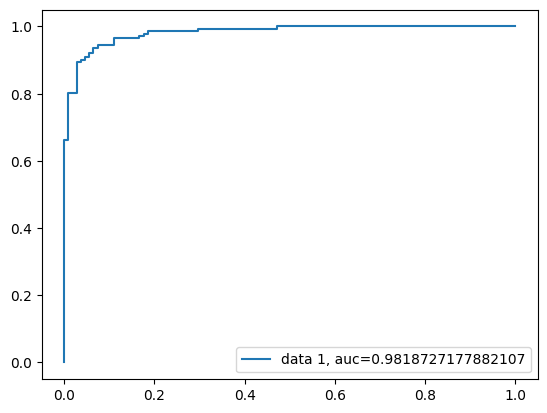

In [101]:
#| echo: false

#Plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test,  y_preds)
auc = metrics.roc_auc_score(y_test, y_preds)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [106]:
#| echo: false

#Identify optimal threshold
optimal_thresh = thresholds[np.argmax(tpr - fpr)]
print(optimal_thresh)

0.6309263284100989


In [107]:
#| echo: false

#Evaluate predictions by comparing labels
y_preds_labels = np.zeros(len(y_preds))
y_preds_labels[y_preds > optimal_thresh] = 1

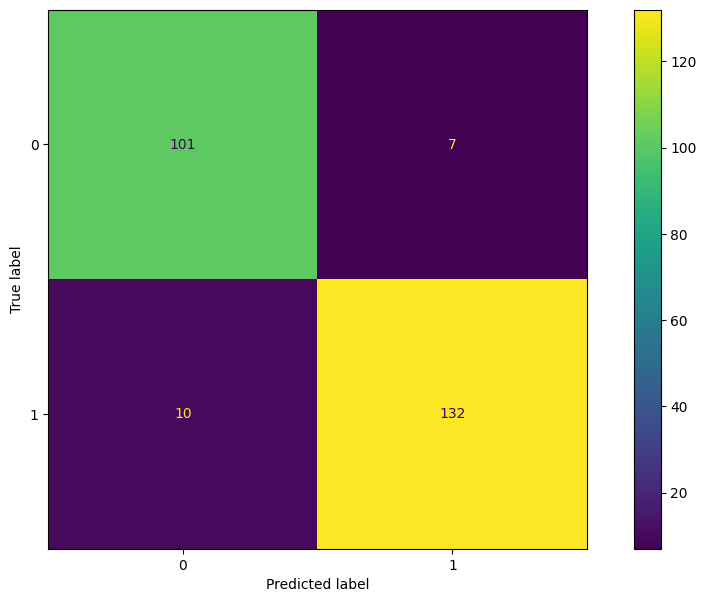

In [126]:
#| echo: false

#Create confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_preds_labels)
cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

fig, ax = plt.subplots(figsize=(12,7))
cm_plot.plot(ax=ax);

In [163]:
#| echo: false

#Calculate classification metrics

print("Accuracy: ", np.mean(y_test.target.to_numpy() == y_preds_labels))
print("Sensitivity: ", round(confusion_matrix[1,1] / (confusion_matrix[1,1] + confusion_matrix[1,0]), 4))
print("Specificity: ", round(confusion_matrix[0,0] / (confusion_matrix[0,0] + confusion_matrix[0,1]), 4))
print("PPV: ", round(confusion_matrix[1,1] / (confusion_matrix[1,1] + confusion_matrix[0,1]), 4))
print("NPV: ", round(confusion_matrix[0,0] / (confusion_matrix[0,0] + confusion_matrix[1,0]), 4))

Accuracy:  0.932
Sensitivity:  0.9296
Specificity:  0.9352
PPV:  0.9496
NPV:  0.9099
